Quora Questions Pairs classification based on Gensim Word2Vec embeddings (Google News corpus)

In [1]:
import gensim
import numpy as np
import pandas as pd
import re
import csv
import os
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Input, Model, Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout

In [ ]:
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading Word2Vec keyed vectors from Google News corpus

In [ ]:
EMBEDDING_FILE = '/content/drive/MyDrive/Copy-CDS-B3/Capstone Project/Data/googlenews/GoogleNews-vectors-negative300.bin.gz'
w2v_model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE,binary=True)

Reading cleaned Quora Questions Pairs Training Data

In [3]:
trainpath = '/content/drive/MyDrive/Copy-CDS-B3/Capstone Project/Data/cleantext/cleaned_train_data.csv'
train_data_tmp = pd.read_csv(trainpath, delimiter=",", encoding='utf-8')
train_data_tmp.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


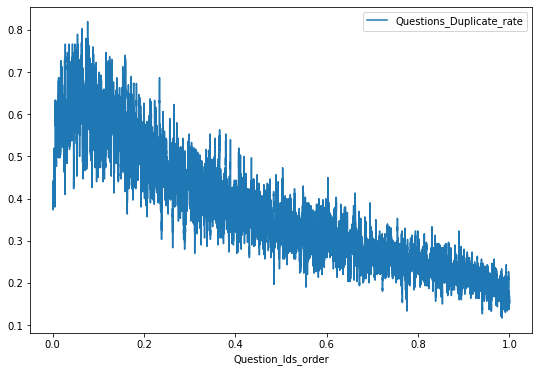

In [11]:
train_df = train_data_tmp.copy()
train_df["qmax"] = train_df.apply( lambda row: max(row["qid1"], row["qid2"]), axis=1 )
train_df = train_df.sort_values(by=["qmax"], ascending=True)
train_df["Questions_Duplicate_rate"] = train_df.is_duplicate.rolling(window=300, min_periods=300).mean()
train_df["Question_Ids_order"] = np.arange(train_df.shape[0]) / float(train_df.shape[0])

train_df.plot(x="Question_Ids_order", y="Questions_Duplicate_rate", kind="line",figsize=(9,6))
plt.show()

Shuffling train data as the qid increases as shown in the above plot - duplicates go down, so shuffling the train data for better model learning

In [ ]:
train_data = train_data_tmp.sample(frac=1)
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
289632,289634,339923,410785,what is the difference between electromotive f...,what are the basic differences among voltage ...,1
222855,222857,138056,330535,how much is one million and one billion in lak...,how much interest does one billion pounds give...,0
275356,275358,394160,394161,us muslim brotherhood participant organizations,punjab mail train,0
28404,28404,52674,52675,is hillary clinton really worse than donald trump,who is better among hillary clinton and donald...,1
56217,56217,98983,98984,what are some characteristics of intj children...,what are intjs like as kids,0


In [ ]:
w2v_model.wv.most_similar(positive=["car"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('vehicle', 0.7821096181869507),
 ('cars', 0.7423830032348633),
 ('SUV', 0.7160962820053101),
 ('minivan', 0.6907036304473877),
 ('truck', 0.6735789775848389),
 ('Car', 0.6677608489990234),
 ('Ford_Focus', 0.667320191860199),
 ('Honda_Civic', 0.662684977054596),
 ('Jeep', 0.6511331796646118),
 ('pickup_truck', 0.64414381980896)]

In [ ]:
# merge questions into vertical list
questions = list(train_data['question1'].astype('str')) + list(train_data['question2'].astype('str'))

In [ ]:
wrdsplitqs = []
for row in questions: 
    wrdsplitqs.append([word for word in row.split()]) 

In [ ]:
vec_data = []
for row in tqdm(wrdsplitqs):
    vec = np.zeros(300)
    for word in row:
        try:
            vec = vec + w2v_model.wv[word]
        except:
            pass
    vec_data.append(vec)

  0%|          | 0/808574 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
100%|██████████| 808574/808574 [00:55<00:00, 14503.49it/s]


In [ ]:
vec_data[0]

array([ 0.48434448,  0.19438934,  1.37744141, -0.34060669, -0.9230957 ,
        0.46069336,  0.39660645, -0.875     ,  1.26318359,  1.04333496,
       -0.71612549, -0.66967773,  0.14575195,  0.95246887, -1.21472168,
        0.97827148, -0.418396  ,  1.00268555, -0.34521484, -0.79595947,
       -0.65637207,  0.42098999, -1.00317383,  0.08617401, -0.07003784,
        0.47277832, -1.328125  ,  0.31811523,  0.19407654,  0.15551758,
       -0.36193848, -0.96044922, -0.11547852, -0.25180054,  0.08164978,
        0.11749268, -0.15771484,  1.86303711,  0.74255371,  0.91621399,
        0.03265381,  0.28369141,  0.02801514, -0.52038574, -1.2020874 ,
       -0.9860611 , -0.0486145 ,  0.14971924, -0.27087402, -0.10668945,
       -0.05200195,  0.71002197, -0.57550049, -0.50244141,  0.02053833,
       -0.31567383,  0.16170502, -0.61276245,  0.0526123 ,  0.09393311,
       -0.60543823,  0.56498718, -0.56829834, -0.01000977, -0.28833008,
       -0.53216553, -0.38885498,  1.89624023, -1.12026978,  0.49

In [ ]:
length = len(vec_data)
half = int(length/2)
first_half = vec_data[:half]
second_half = vec_data[length-half:]

In [ ]:
q1_arry = np.array(first_half)
q2_arry = np.array(second_half)

In [ ]:
q1_arry.shape, q2_arry.shape

((404287, 300), (404287, 300))

In [ ]:
tem_df1 = pd.DataFrame(q1_arry, index= train_data.index)
tem_df2 = pd.DataFrame(q2_arry, index= train_data.index)
tem_df = pd.concat([tem_df1, tem_df2], axis=1)

In [ ]:
final_df = pd.concat([tem_df, train_data['is_duplicate']], axis=1)
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,is_duplicate
289632,0.484344,0.194389,1.377441,-0.340607,-0.923096,0.460693,0.396606,-0.875000,1.263184,1.043335,...,-0.722046,-0.983948,-0.384964,-0.941162,-0.028748,-0.186096,0.128021,0.573853,0.242432,1
222855,1.272675,0.258667,0.729858,2.215454,-0.721191,-0.864868,0.987625,-1.008301,1.017334,-0.342712,...,-0.158768,-0.833923,-0.179932,-0.267700,0.268253,0.233887,-0.329664,-0.333496,-0.861992,0
275356,0.217041,-0.321106,0.472977,1.467285,0.004456,0.462952,-0.297302,0.028564,0.256836,0.370605,...,-0.170898,0.070801,-0.110474,0.236969,0.078308,-0.912109,0.479248,0.051590,-0.141846,0
28404,-0.117554,0.198242,0.125885,1.291138,-1.161621,0.130127,0.077103,-0.303665,0.627502,0.546753,...,0.117554,-0.535889,-0.006836,-0.483643,-0.734131,-0.067078,-0.751709,-0.038818,0.880249,1
56217,0.882324,0.366806,0.525078,1.124512,-1.582031,0.351135,0.699585,-0.441864,0.260322,-0.019653,...,0.027100,-0.562256,-0.179932,-0.373535,0.398926,0.248726,-0.015503,0.399414,-0.109619,0


In [ ]:
import gc
del(train_df)
del(w2v_model)
del(train_data_tmp)
del(wrdsplitqs)
del(vec_data)
del(q1_arry)
del(q2_arry)
del(tem_df)
del(tem_df1)
del(tem_df2)
gc.collect()

102

In [ ]:
sentences = final_df.iloc[:,:-1].values
y = pd.DataFrame(data=final_df.is_duplicate)
#y = final_df['is_duplicate'].values

In [ ]:
questions_train, questions_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = metrics.confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    B =(C/C.sum(axis=0))
    #divide each element of the confusion matrix with the sum of elements in that row
    
    plt.figure(figsize=(20,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

def print_modelpred_metrics(y_test,y_pred):
    prediction = np.round(abs(y_pred))
    print ('Accuracy:  ', accuracy_score(y_test, prediction))
    print ('F1 score:  ', f1_score(y_test, prediction))
    print ('Recall:    ', recall_score(y_test, prediction))
    print ('Precision: ', precision_score(y_test, prediction))
    print ('\nclasification report:\n\n', classification_report(y_test,prediction))
    print ('\n confussion matrix:\n\n',confusion_matrix(y_test, prediction))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
questions_train = scaler.fit_transform(questions_train)

In [ ]:
X_1_train, X_2_train = questions_train[:,:300],questions_train[:,300:]
X_1_train.shape,X_2_train.shape

((323429, 300), (323429, 300))

In [ ]:
del(final_df)
del(questions_train)
del(sentences)
gc.collect()

235

In [ ]:
from keras import layers
from keras.models import Input, Model, Sequential
from keras.layers import Concatenate, Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

ishape = X_1_train.shape[1]
inputs1 = Input(shape=ishape)
inputs2 = Input(shape=ishape)

sharedBranch = layers.Dense(300, activation="tanh")

branch1 = sharedBranch(inputs1)
branch2 = sharedBranch(inputs2)

concatenated1 = Concatenate( name='Concatenate_1')([branch1,branch2])

final_model = layers.Dense(128, activation="relu")(concatenated1)
final_model = layers.Dropout(0.2)(final_model)
final_model = layers.Dense(64, activation="relu")(final_model)
final_model = layers.Dropout(0.2)(final_model)
output = layers.Dense(1, activation="sigmoid")(final_model)

mainmodel = Model(inputs=[inputs1,inputs2], outputs=output)

In [ ]:
mainmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=0, mode='auto')
history = mainmodel.fit([X_1_train, X_2_train], y_train, batch_size=100, epochs=20, verbose=1,callbacks=[early], validation_split=0.1)

Epoch 1/20
2911/2911 [==============================] - 11s 4ms/step - loss: 0.5099 - accuracy: 0.7378 - val_loss: 0.4577 - val_accuracy: 0.7726
Epoch 2/20
2911/2911 [==============================] - 10s 3ms/step - loss: 0.4476 - accuracy: 0.7776 - val_loss: 0.4301 - val_accuracy: 0.7913
Epoch 3/20
2911/2911 [==============================] - 10s 3ms/step - loss: 0.4169 - accuracy: 0.7973 - val_loss: 0.4148 - val_accuracy: 0.7997
Epoch 4/20
2911/2911 [==============================] - 10s 3ms/step - loss: 0.3919 - accuracy: 0.8133 - val_loss: 0.4067 - val_accuracy: 0.8011
Epoch 5/20
2911/2911 [==============================] - 10s 3ms/step - loss: 0.3693 - accuracy: 0.8265 - val_loss: 0.4027 - val_accuracy: 0.8077
Epoch 6/20
2911/2911 [==============================] - 10s 3ms/step - loss: 0.3488 - accuracy: 0.8373 - val_loss: 0.4021 - val_accuracy: 0.8103
Epoch 7/20
2911/2911 [==============================] - 10s 4ms/step - loss: 0.3312 - accuracy: 0.8476 - val_loss: 0.3985 - val_ac

In [ ]:
questions_test = scaler.transform(questions_test)

In [ ]:
X_1_test, X_2_test = questions_test[:,:300],questions_test[:,300:]
X_1_test.shape,X_2_test.shape

((80858, 300), (80858, 300))

In [ ]:
y_pred = mainmodel.predict([X_1_test, X_2_test])

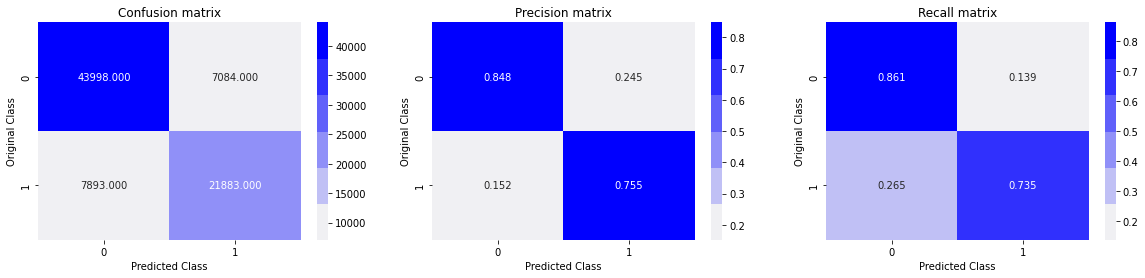

In [ ]:
plot_confusion_matrix(y_test, np.round(abs(y_pred)))

In [ ]:
print_modelpred_metrics(y_test,y_pred)

Accuracy:   0.8147740483316431
F1 score:   0.7450419624465894
Recall:     0.7349207415368082
Precision:  0.7554458521766148

clasification report:

               precision    recall  f1-score   support

           0       0.85      0.86      0.85     51082
           1       0.76      0.73      0.75     29776

    accuracy                           0.81     80858
   macro avg       0.80      0.80      0.80     80858
weighted avg       0.81      0.81      0.81     80858


 confussion matrix:

 [[43998  7084]
 [ 7893 21883]]


In [ ]:
y_test.head()

,is_duplicate
187418,1
87896,0
114704,0
345561,0
201688,0


In [ ]:
y_test1 = y_test.copy()
y_test1['pred_prob'] = y_pred
y_test1['rounded_pred'] = np.round(abs(y_pred))
mergedf = pd.merge(train_data[['question1','question2']], y_test1, left_index = True, right_index = True)
mergedf.to_csv('qqp_word2vec_predicted_output.csv')